In [1]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os
os.environ['GOOGLE_API_KEY']=""
llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash",temperature="0.60")
llm.invoke("Hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run-535eed8d-dfd5-4689-bb8b-5d681c269045-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [3]:
llm_tools=llm.bind_tools([multiply])

In [11]:
ans=llm_tools.invoke("What is 2 * 5")

In [16]:
from langchain_core.messages import AIMessage, HumanMessage
ans=llm_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [17]:
ans

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run-af22ae08-02f5-4b4e-b6d2-cba64d4cec7b-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '6533e029-5071-4944-a3db-cce8e7146e59', 'type': 'tool_call'}], usage_metadata={'input_tokens': 22, 'output_tokens': 3, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}})

In [19]:
ans.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': '6533e029-5071-4944-a3db-cce8e7146e59',
  'type': 'tool_call'}]

In [20]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [21]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [22]:
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='fbc9c6ec-4d23-4473-938e-39f2a80d4896'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='99a4783a-7f67-43fe-8add-c06343420b06'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='98201499-14c6-466b-9701-4c5a78abd35e')]

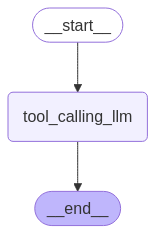

In [27]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you today?


In [29]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (701328ee-8044-464c-a204-6bbb12f5fd9d)
 Call ID: 701328ee-8044-464c-a204-6bbb12f5fd9d
  Args:
    a: 2.0
    b: 3.0


In [30]:
messages

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d87c7c0b-426c-49b7-9e84-fd80774caa80'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run-baf311c8-3681-4ccf-8c09-1e04704a9086-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '701328ee-8044-464c-a204-6bbb12f5fd9d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 20, 'output_tokens': 3, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})]}

In [35]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

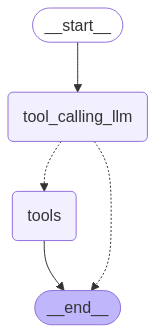

In [36]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
graph.invoke({"messages":"What is multilpication of 2* 5"})

{'messages': [HumanMessage(content='What is multilpication of 2* 5', additional_kwargs={}, response_metadata={}, id='d7578fd5-97b9-420f-9b10-31998777668c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 5.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run-4cc1309c-095c-440f-90ea-1e617cf899bc-0', tool_calls=[{'name': 'multiply', 'args': {'b': 5.0, 'a': 2.0}, 'id': '66217f24-f102-422d-b9b2-b884f0e4625f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 25, 'output_tokens': 3, 'total_tokens': 28, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='10', name='multiply', id='a4914b4d-8d79-4550-b375-913b72c768ec', tool_call_id='66217f24-f102-422d-b9b2-b884f0e4625f')]}